In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
import random
import torch
import pdb

c:\Users\Brico\miniconda3\envs\monai\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def batch_one_hot_encode(batch_segmentation_maps, num_classes):
    """
    Perform one-hot encoding on a batch of segmentation maps.

    Args:
    - batch_segmentation_maps (torch.Tensor): Batch of segmentation map tensors with class indices.
      Shape: (batch_size, H, W)
    - num_classes (int): Number of classes in the segmentation task.

    Returns:
    - torch.Tensor: Batch of one-hot encoded tensors.
      Shape: (batch_size, num_classes, H, W)
    """
    # Ensure the batch_segmentation_maps is a PyTorch tensor
    batch_segmentation_maps = torch.tensor(batch_segmentation_maps)

    # Ensure the batch_segmentation_maps has the correct shape (batch_size, H, W)
    if len(batch_segmentation_maps.shape) != 3:
        raise ValueError("Batch segmentation maps should be a 3D tensor (batch_size, H, W).")

    # Create a zero-filled tensor with dimensions (batch_size, num_classes, H, W)
    batch_one_hot = torch.zeros((batch_segmentation_maps.shape[0], num_classes, 
                                 batch_segmentation_maps.shape[1], batch_segmentation_maps.shape[2]))

    # Fill in the one-hot tensor based on class indices for each batch
    for batch_idx in range(batch_segmentation_maps.shape[0]):
        for class_idx in range(num_classes):
            batch_one_hot[batch_idx, class_idx, :, :] = (
                batch_segmentation_maps[batch_idx, :, :] == class_idx
            ).float()

    return to_var(batch_one_hot)

# Example usage:
# Assuming batch_segmentation_maps is your batch of segmentation map tensors with class indices
# and num_classes is the number of classes in your segmentation task.
batch_segmentation_maps = torch.tensor([[[0, 1, 0], [2, 1, 2], [0, 1, 2]],
                                        [[2, 0, 1], [1, 2, 0], [0, 2, 1]]])
num_classes = 3

batch_one_hot_encoded = batch_one_hot_encode(batch_segmentation_maps, num_classes)
print(batch_one_hot_encoded.shape)

torch.Size([2, 3, 3, 3])


In [4]:
def out_to_seg(img, num_classes):
    out = torch.zeros((1,*img.shape[1:])).to(img.device)
    for i,layer in enumerate(img) :
        out += layer*(i*255/(num_classes-1))
    return out
out_to_seg(batch_one_hot_encoded[0],3)

tensor([[[  0.0000, 127.5000,   0.0000],
         [255.0000, 127.5000, 255.0000],
         [  0.0000, 127.5000, 255.0000]]], device='cuda:0')

In [6]:
from numpy import isnan


def runTraining():
    print('-' * 40)
    print('~~~~~~~~  Starting the training... ~~~~~~')
    print('-' * 40)

    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 8
    batch_size_val = 8
    lr =   0.01  # Learning Rate
    epoch = 50 # Number of epochs
    
    root_dir = './Data/'

    print(' Dataset: {} '.format(root_dir))

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                      root_dir,
                                                      transform=transform,
                                                      mask_transform=mask_transform,
                                                      augment=True,
                                                      equalize=True)

    train_loader_full = DataLoader(train_set_full,
                              batch_size=batch_size,
                              worker_init_fn=np.random.seed(0),
                              num_workers=0,
                              shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    equalize=False)

    val_loader = DataLoader(val_set,
                            batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = 'Test_Model'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = UNet(num_classes)

    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax()
    CE_loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.2,0,0,0.8]), reduction="sum")

    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    ### To save statistics ####
    lossTotalTraining = []
    Best_loss_val = 1000
    BestEpoch = 0
    
    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING
    
    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train()
        lossEpoch = []
        DSCEpoch = []
        DSCEpoch_w = []
        num_batches = len(train_loader_full)
        
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)
            
            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = softMax(net(images))
            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            encoded_classes = batch_one_hot_encode(segmentation_classes, num_classes)
            # COMPUTE THE LOSS
            CE_loss_value = CE_loss(net_predictions, encoded_classes) # XXXXXX and YYYYYYY are your inputs for the CE
            element_by_layers = predToSegmentation(net_predictions).sum(dim=(2,3))
            prob_by_layer = (element_by_layers/(element_by_layers.sum()))
            piecewise_diff = prob_by_layer - torch.Tensor([0.8,0,0,0.2]).to(prob_by_layer.device)
            shannon = torch.pow(piecewise_diff, 2)
            lossTotal = CE_loss_value
            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            CE_loss_value.backward()
            optimizer.step()
            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(lossTotal.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                             prefix="[Training] Epoch: {} ".format(i) ,
                            length=15,
                             suffix=" Loss: {:.4f}, ".format(lossTotal))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()

        lossTotalTraining.append(lossEpoch)

        printProgressBar(num_batches, num_batches,
                             done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))

        
        ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        if not os.path.exists('./models/' + modelName):
            os.makedirs('./models/' + modelName)
        if i == epoch-1:
            torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
            
        np.save(os.path.join(directory, 'Losses.npy'), lossTotalTraining)


In [7]:
runTraining()

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
 Dataset: ./Data/ 
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 962,452
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
[Training] Epoch: 0 [DONE]                                     
[Training] Epoch: 0, LossG: 107850.4453                                                                      
[Training] Epoch: 1 [DONE]                                     
[Training] Epoch: 1, LossG: 81161.7344                                                                       
[Training] Epoch: 2 [DONE]                                     
[Training] Epoch: 2, LossG: 80303.7578                                                                       
[Training] Epoch: 3 [DONE]                                     
[Training] Epoch: 3, LossG: 80242.0078                                                                       
[Training] Epoch: 4 [DO

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
mod = UNet(num_classes=4).cuda()
mod.load_state_dict(torch.load("models/Test_Model/49_Epoch"))
transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [9]:
val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    "./Data/",
                                                    transform=transform,
                                                    mask_transform=transform,
                                                    equalize=False)

val_loader = DataLoader(val_set,
                            batch_size=2,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)
inference(mod, val_loader, "Test_Model", 99)

[Inference] Segmentation Done !                                                                              


0.3938426

torch.return_types.max(
values=tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]),
indices=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]))


(tensor([0.0000, 0.3333, 0.6667, 1.0000]),
 './Data/val\\Img\\patient001_01_4.png')

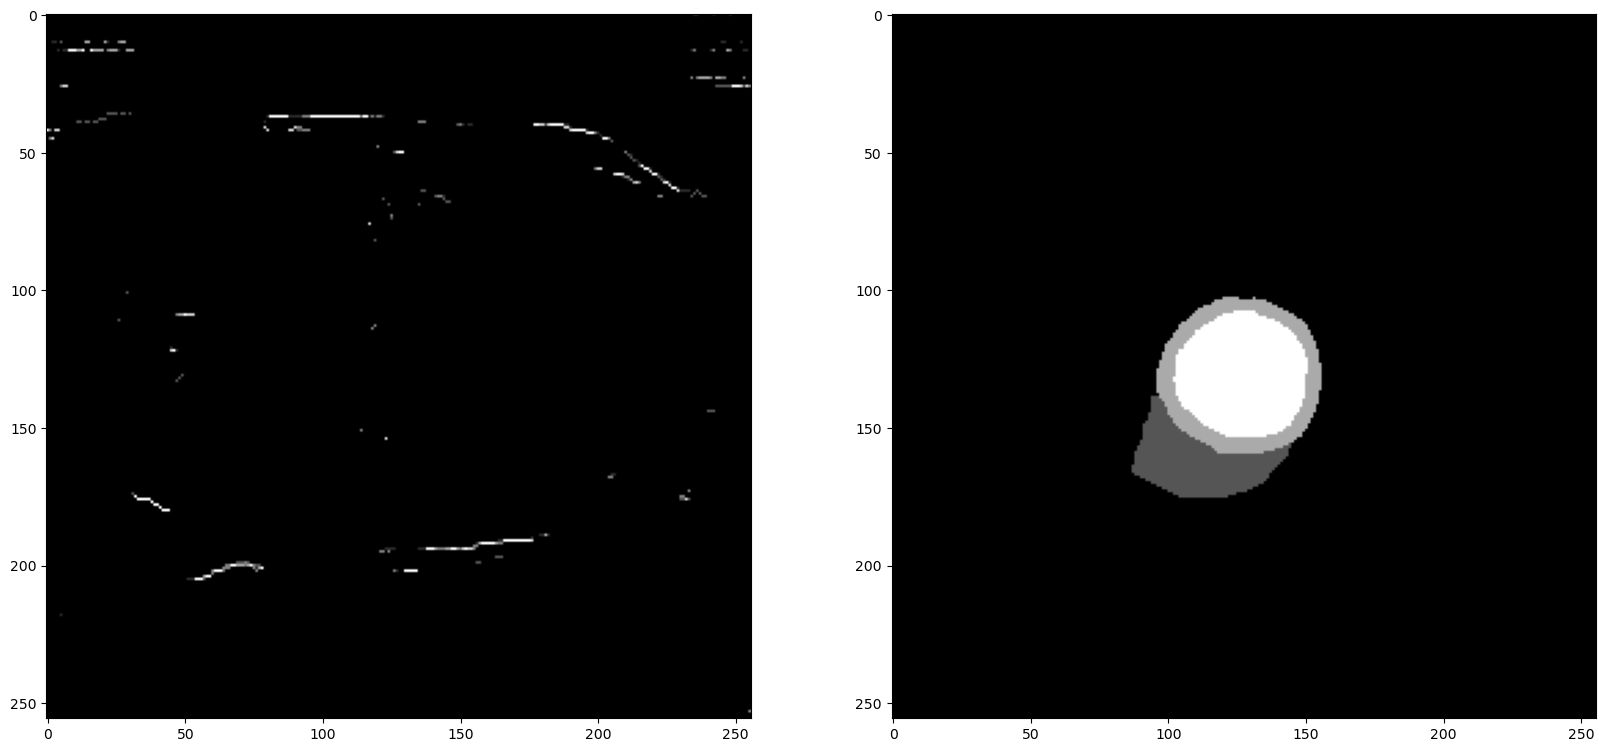

In [12]:
img, mask, path = val_set[4]
out = mod(to_var(img)[None,:])
out_cpu =out.detach().cpu()[0]
out_cpu = torch.nn.functional.softmax(out_cpu, dim=0)
segmentation_image = out_to_seg(predToSegmentation(out_cpu),3)

# Now, concatenated_output has shape (batch_size, 1, num_classes, height, width)
# If you want to remove the singleton dimension, you can use squeeze
print(out_cpu.max(dim=0))
fig, plots = plt.subplots(1,2, figsize=(20,20))
plots[0].imshow(segmentation_image.permute(1,2,0), cmap="gray")
plots[1].imshow(mask.permute(1,2,0), cmap="gray")
mask.unique(), path
